<a href="https://colab.research.google.com/github/hinhnv/decode-qam-use-deep-learning/blob/main/32QAM_ML_loop_07012024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Flatten, Convolution2D, Dropout, BatchNormalization,Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
dBms = list(range(0,1))

In [ ]:
# define tham so dieu che
M = 32
# mode = 'GG_PhaseEr'
mode = 'GG_PointErr'

0
NN
Epoch 1/10
2344/2344 [==============================] - 26s 8ms/step - loss: 2.3353 - accuracy: 0.3263 - val_loss: 2.2817 - val_accuracy: 0.3422
Epoch 2/10
2344/2344 [==============================] - 18s 8ms/step - loss: 2.3097 - accuracy: 0.3370 - val_loss: 2.2742 - val_accuracy: 0.3455
Epoch 3/10
2344/2344 [==============================] - 19s 8ms/step - loss: 2.3070 - accuracy: 0.3390 - val_loss: 2.2721 - val_accuracy: 0.3446
Epoch 4/10
2344/2344 [==============================] - 20s 8ms/step - loss: 2.3038 - accuracy: 0.3400 - val_loss: 2.2714 - val_accuracy: 0.3476
Epoch 5/10
2344/2344 [==============================] - 19s 8ms/step - loss: 2.3019 - accuracy: 0.3409 - val_loss: 2.2652 - val_accuracy: 0.3486
Epoch 6/10
2344/2344 [==============================] - 19s 8ms/step - loss: 2.3006 - accuracy: 0.3413 - val_loss: 2.2719 - val_accuracy: 0.3468
Epoch 7/10
2344/2344 [==============================] - 21s 9ms/step - loss: 2.3000 - accuracy: 0.3420 - val_loss: 2.2722 - v

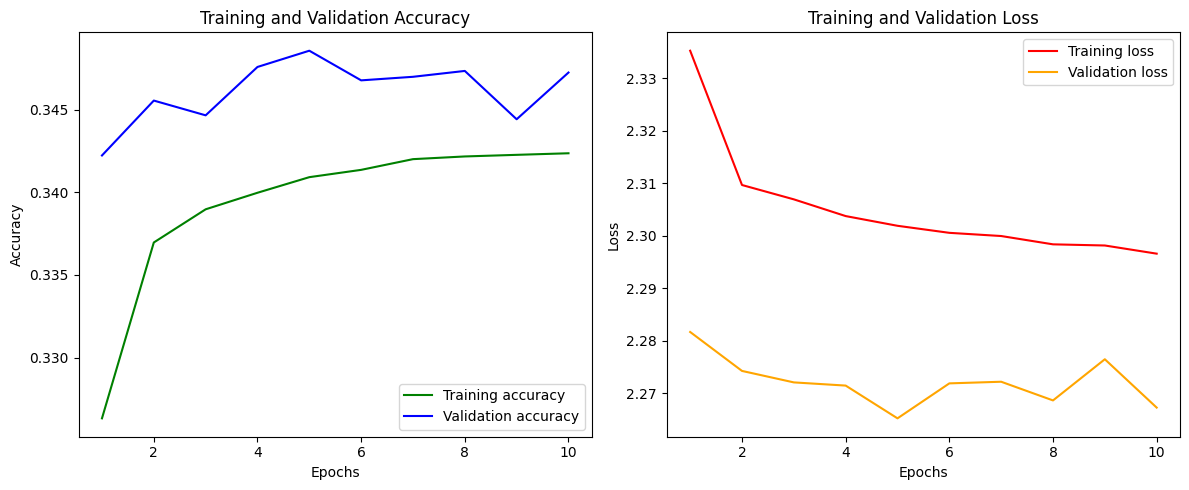

12500/12500 [==============================] - 26s 2ms/step
394681
[0.2174926, 0.1973405]


In [ ]:
# Mở tệp CSV để ghi
with open('result_QAM_' + mode + '.csv',  mode='a', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    csv_writer.writerow(['Ber Mo phong','Ber Neural Network'])

    for dBm in dBms:
        # Load the .mat file
        print(dBm)
        datasets = scipy.io.loadmat('/content/drive/MyDrive/QAM/' + str(M) + 'QAM/data_32QAM_' + mode + '_' + str(dBm) + 'dBm.mat')

        # Access the variables in the .mat file

        data = datasets['data']
        data_noise = datasets['data_noise'][0]
        data_label = datasets['data_complex'][0]
        SNR = datasets['SNR'][0][0]
        ber_montecarlo = datasets['BER_simul'][0][0]

        data_noise_real = data_noise.real
        data_noise_imag = data_noise.imag
        # Load your data
        X = np.column_stack((data_noise_real, data_noise_imag))

        # Khoảng cách tuyệt đối
        abs_distance_real = np.abs(data_noise_real)
        abs_distance_imag = np.abs(data_noise_imag)

        # Khoảng cách Euclidean
        euclidean_distance = np.sqrt(data_noise_real**2 + data_noise_imag**2)

        # Thêm các đặc trưng mới vào X
        X = np.column_stack((X, abs_distance_real, abs_distance_imag, euclidean_distance))

        # label
        y = data.ravel()

        # print(data)

        # Split the data into training and testing sets
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        # Scale lai du lieu
        # scaler = StandardScaler()
        # X_train = scaler.fit_transform(X_train)
        # X_test = scaler.transform(X_test)
        # X_val = scaler.transform(X_val)

        print("NN")
        # Mã hoá one-hot cho y_train và y_test nếu cần
        # y_train_encoded = to_categorical(y_train)
        # y_test_encoded = to_categorical(y_test)
        # Define a simple neural network model
        # Tạo một mô hình Sequential

        # Tạo mô hình ResNet50 cho việc trích xuất đặc trưng

        model = Sequential()

        # Thêm các layer

        model.add(Dense(1024, input_shape=(5, ), activation='relu'))
        model.add(BatchNormalization())  # Lớp chuẩn hóa
        model.add(Dropout(0.3))  # Dropout để giảm overfitting

        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(M, activation='softmax'))


        # Compile mô hình với optimizer và hàm loss
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.000001)
        optimizer = Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        # model.compile(optimizer=optimizer,
        #               loss='mse',
        #               metrics=['accuracy'])

        # Huấn luyện mô hình với dữ liệu
        # history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val, y_val),  callbacks=[reduce_lr])
        history = model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_val, y_val))


        import matplotlib.pyplot as plt
        # Lấy thông tin về accuracy và loss từ quá trình huấn luyện
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(train_accuracy) + 1)

        # Vẽ đồ thị accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Vẽ đồ thị loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'orange', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        predicted_probabilities = model.predict(X_test)

        # Lấy chỉ số của lớp có xác suất cao nhất
        predicted_class = np.argmax(predicted_probabilities, axis=1)

        prediction_bin = [list(bin(num)[2:].zfill(5)[::-1]) for num in predicted_class]
        y_test_bin = [list(bin(num)[2:].zfill(5)[::-1]) for num in y_test]

        # Kiểm tra nếu các danh sách có cùng độ dài và tìm số lỗi bit
        if len(prediction_bin) == len(y_test_bin):
            nBitErr = sum([1 for i in range(len(prediction_bin)-1) for j in range(len(prediction_bin[i])-1) if prediction_bin[i][j] != y_test_bin[i][j]])
            print(nBitErr)
        else:
            print("Độ dài của các danh sách không khớp nhau.")

        ber_nn = nBitErr/(len(X_test)*5)

        # # Calculate the accuracy of the neural network model
        # accuracy_nn = accuracy_score(y_test, y_pred_nn)

        values = [ber_montecarlo, ber_nn]
        print(values)
        csv_writer.writerow(values)

In [ ]:
# predicted_probabilities = model.predict(X_test)

# # Lấy chỉ số của lớp có xác suất cao nhất
# predicted_class = np.argmax(predicted_probabilities, axis=1)

# prediction_bin = [list(bin(num)[2:].zfill(5)[::-1]) for num in predicted_class]
# y_test_bin = [list(bin(num)[2:].zfill(5)[::-1]) for num in y_test]

# # Kiểm tra nếu các danh sách có cùng độ dài và tìm số lỗi bit
# if len(prediction_bin) == len(y_test_bin):
#     nBitErr = sum([1 for i in range(len(prediction_bin)-1) for j in range(len(prediction_bin[i])-1) if prediction_bin[i][j] != y_test_bin[i][j]])
#     print(nBitErr)
# else:
#     print("Độ dài của các danh sách không khớp nhau.")

# ber_nn = nBitErr/(len(X_test)*5)

# # # Calculate the accuracy of the neural network model
# # accuracy_nn = accuracy_score(y_test, y_pred_nn)

# values = [ber_montecarlo, ber_nn]
# print(values)

In [ ]:
for dBm in dBms:
        # Load the .mat file
        print(dBm)
        datasets = scipy.io.loadmat('/content/drive/MyDrive/QAM/' + str(M) + 'QAM/data_32QAM_' + mode + '_' + str(dBm) + 'dBm.mat')

        # Access the variables in the .mat file

        data = datasets['data']
        data_noise = datasets['data_noise'][0]
        data_label = datasets['data_complex'][0]
        SNR = datasets['SNR'][0][0]
        ber_montecarlo = datasets['BER_simul'][0][0]

        data_noise_real = data_noise.real
        data_noise_imag = data_noise.imag
        # Load your data
        X = np.column_stack((data_noise_real, data_noise_imag))

        # Khoảng cách tuyệt đối
        abs_distance_real = np.abs(data_noise_real)
        abs_distance_imag = np.abs(data_noise_imag)

        # Khoảng cách Euclidean
        euclidean_distance = np.sqrt(data_noise_real**2 + data_noise_imag**2)

        # Thêm các đặc trưng mới vào X
        X = np.column_stack((X, abs_distance_real, abs_distance_imag, euclidean_distance))

        # label
        y = data.ravel()

        # print(data)

        # Split the data into training and testing sets
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# model_class.classifier = nn.Sequential(
#     nn.Linear(classifier_input, 128),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Flatten(),
#     nn.Dropout(0.5),
#     nn.Linear(128, 2), # Since 100 possible outputs
#     nn.LogSoftmax(dim=1) # For using NLLLoss()
# )

# # Convert model to be used on GPU
# model_class = model_class.to(device)

In [ ]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNormf1d(1024)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.to(self.fc1.weight.device)  # Ensure input is on the same device as the model parameters

        x = self.dropout1(self.bn1(torch.relu(self.fc1(x))))
        x = self.dropout2(self.bn2(torch.relu(self.fc2(x))))
        x = self.dropout3(self.bn3(torch.relu(self.fc3(x))))
        x = self.dropout4(self.bn4(torch.relu(self.fc4(x))))
        x = self.fc5(x)
        return x


# Load your data (assuming X, y are your data and labels)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)



# Convert model to be used on GPU

# Create the model instance
model = SimpleNN(input_size=5, num_classes=M).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
# Training loop

for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')
